In [63]:
import matplotlib.pyplot as plt
import numpy as np
#from braket.aws import AwsDevice
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator


from qiskit import QuantumCircuit
from qiskit import qasm3


from utils_qpe import run_qpe

from braket.experimental.algorithms.quantum_phase_estimation import (
    get_quantum_phase_estimation_results,
    run_quantum_phase_estimation,
    quantum_phase_estimation_circuit,
)

In [86]:

def haar_random_unitary(d: int, rng: np.random.Generator | None = None) -> np.ndarray:
    """
    Generate a d×d Haar-random unitary using QR decomposition.

    Args:
        d: Dimension of the unitary.
        rng: Optional numpy random Generator for reproducibility.

    Returns:
        U: A (d, d) complex numpy array distributed according to the Haar measure on U(d).
    """
    if d <= 0:
        raise ValueError("d must be a positive integer.")
    rng = rng or np.random.default_rng()

    # Complex Ginibre matrix (i.i.d. complex normal entries)
    z = (rng.normal(size=(d, d)) + 1j * rng.normal(size=(d, d))) / np.sqrt(2.0)

    # QR decomposition
    q, r = np.linalg.qr(z)

    # Fix phases to make Q Haar: normalize diagonal of R to unit magnitude
    diag = np.diag(r)
    phases = diag / np.abs(diag)
    phases[np.abs(diag) == 0] = 1.0  # safeguard (extremely unlikely)

    U = q * phases  # broadcast phases across columns

    return U

def random_circuit_state(circ, qubits, depth =3, rng = None):
    rng = rng or np.random.default_rng()

    for _ in range(depth):
        for q in qubits:
            theta, phi, lam = rng.uniform(0,2*np.pi, size = 3)
            circ.u(q, theta, phi, lam) #most general rotation
        for i in range(len(qubits)-1):
            circ.cnot(qubits[i], qubits[i+1])
    return circ

def split_bitstring(bitstring )-> tuple[int,int]:
    """

    :param bitstring:
    :return: integers representing the bitstring. Split bitstring in half
    """
    d = int(len(bitstring) / 2)
    first = bitstring[:d]
    second = bitstring[d:]
    return int(first,2), int(second,2)

def cyclic_distance(a,b,d):
    """Compute cyclci distance |a-b| mod 2^d"""

    M = 2**d
    diff = abs(a-b)
    return min(diff, M-diff)

def within_delta(bitstring, delta) -> bool:
    d = int(len(bitstring) / 2)
    m1, m2 = split_bitstring(bitstring)
    return cyclic_distance(m1, m2, d) <= delta


For now should see if I can compare the measurement result of the QPE circuit and apply the QPE circuit once more and see if the measuremente results are indeed the same

Some Major problem is actually implementing the unitary. trying to input an actual matirx is usually only supported with Localsimulator and won't work or scale with acutal QPUs. Alternative would be to implement a random circuit with gates available to these QPUs. Have to come up with one or do a security proof again with the given randomness.

In [72]:
# Define Pauli matrices
Id = np.eye(2)  # Identity matrix
X = np.array([[0.0, 1.0], [1.0, 0.0]])  # Pauli X
Y = np.array([[0.0, -1.0j], [1.0j, 0.0]])  # Pauli Y
Z = np.array([[1.0, 0.0], [0.0, -1.0]])  # Pauli Z

In [77]:
d = 4 # dimension of ancilla. Relates to precision
D = 2 # Unitary dimension
delta = 1 # Boundary value

In [92]:
first_precision_qubit = list(range(1, d + 1))
second_precision_qubit = list(range(d + 1, d + d + 1))
target_qubit = list(range(d + d + 1, d + d + 1 + D))

rng = np.random.default_rng(seed = 4)
unitary = haar_random_unitary(2**D,rng)

In [93]:
print(len(unitary))
print(len(target_qubit))
print(first_precision_qubit)
print(second_precision_qubit)
print(target_qubit)

4
2
[1, 2, 3, 4]
[5, 6, 7, 8]
[9, 10]


In [94]:
# Build Circuit
qpe_circ = Circuit()

#inititalise target qubits with random state
qpe_circ = random_circuit_state(qpe_circ, target_qubit, depth = 3 )
qpe_circ.qpe(first_precision_qubit, target_qubit, unitary)
qpe_circ.measure(first_precision_qubit)

qpe_circ.i(target_qubit)

qpe_circ.qpe(second_precision_qubit, target_qubit, unitary)
qpe_circ.measure(second_precision_qubit)



Circuit('instructions': [Instruction('operator': U('angles': (5.528252464646607, 0.9387770146396538, 0.6716221711022679), 'qubit_count': 1), 'target': QubitSet([Qubit(9)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': U('angles': (5.543251279002802, 3.5344003841606453, 4.4491094730885115), 'qubit_count': 1), 'target': QubitSet([Qubit(10)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': CNot('qubit_count': 2), 'target': QubitSet([Qubit(9), Qubit(10)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': U('angles': (2.303172547704794, 1.0002375376241837, 2.4537402001938964), 'qubit_count': 1), 'target': QubitSet([Qubit(9)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': U('angles': (1.3129944202897905, 1.3606216871290435, 2.3828804428380503), 'qubit_count': 1), 'target': QubitSet([Qubit(10)]), 'control': QubitSet([]), 'control_state': (), 'power'

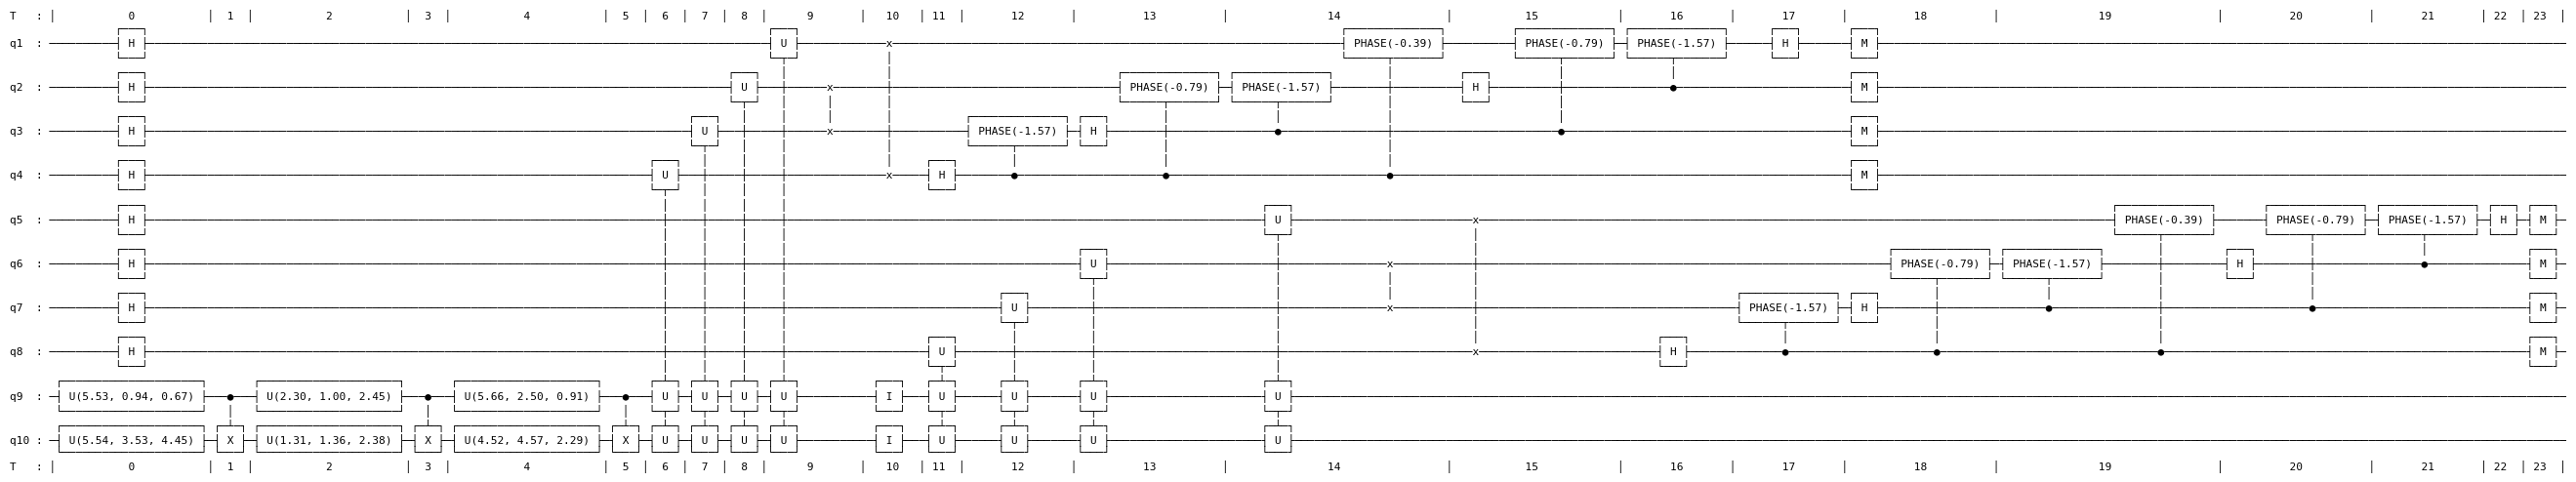

In [95]:
#Visualise
diagram = qpe_circ.diagram()
plt.figure(figsize = (24,6))
plt.axis('off')
plt.text(
    0,1,diagram,
    family = 'monospace',
    fontsize = 8,
    va = 'top'
)
plt.show()

In [96]:
result = LocalSimulator().run(qpe_circ, shots = 2000).result()
print(result.measurement_counts)

Counter({'00000000': 761, '00000011': 659, '11001111': 129, '11000011': 112, '11111111': 96, '00001100': 84, '00001111': 29, '11111100': 25, '11110011': 20, '11000000': 16, '00110011': 16, '11110000': 15, '00110000': 14, '00111111': 9, '11001100': 8, '00111100': 7})


In [97]:
m_result = result.measurement_counts

total_shots = sum(m_result.values())
accepted_shots = sum(
    count for bitstring, count in m_result.items()
    if within_delta(bitstring, delta)
)

acceptance_rate = accepted_shots / total_shots

In [98]:
print(acceptance_rate)

0.4625
